# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt

%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Clean Portfolio Data
There's a bit of cleaning that needs to be done on the **portfolio** dataset. In particular:
* Dummy encode _channels_,
* Dummy encode _offer_type_
* Convert duration to hours (currently in days)

In [2]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [3]:
def get_unique_items(dataframe, column):
    """
    INPUT:
    dataframe - the dataframe to use
    column - the name of the column to expand
    
    OUTPUT:
    unique_items - list of unique items in that column
    
    """
    list_of_lists = list(dataframe[f'{column}'])
    flatten = [y for x in list_of_lists for y in x]
    unique_items = list(set(flatten))
    
    return unique_items

unique_channels = get_unique_items(portfolio, 'channels')
unique_channels

['web', 'email', 'mobile', 'social']

In [4]:
def clean_portfolio(dataframe):
    '''
    Cleaning the portfolio dataframe
    
    INPUT:
    dataframe - the dataframe to be cleaned
    
    OUTPUT:
    portfolio - the cleaned dataframe
    
    '''
    df = portfolio.copy()
    for item in unique_channels:
        df[f'{item}'] = df['channels'].apply(lambda x: 1 if item in x else 0)
    
    offer_type = pd.get_dummies(df['offer_type'])
    df = pd.concat([df, offer_type], axis=1)
    
    df = df.drop(columns=['channels', 'offer_type'])
    
    df['duration'] = df['duration'] * 24
        
    return df

cleaned_portfolio = clean_portfolio(portfolio)
cleaned_portfolio
    

,reward,difficulty,duration,id,web,email,mobile,social,bogo,discount,informational
0,10,10,168,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,96,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,0,1
3,5,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0
4,5,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,1,0
5,3,7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,10,240,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,0,72,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,0,0,1
8,5,5,120,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,168,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,0,1,0


## Clean Transcript
**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

To begin, let's look at the top rows:


In [5]:
transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [6]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

We can see that the data contains information on transactions that were not influenced by an offer. This is encoded by _transaction_. We're going to want to filter those out, and then create a cleaned matrix.

In [7]:
transcript_copy = transcript.copy()
transcript_copy = transcript_copy[transcript_copy['event'] != 'transaction']

Now let's extract the offer id's from each piece. We can see that the keys are encoded differently. Let's see if we can figure out the patterns.

In [8]:
keys = []
for item in list(transcript_copy['value']):
    keys += list(item.keys())
keys = set(keys)
keys

{'offer id', 'offer_id', 'reward'}

Now that we know what the unique keys are, let's see how these play out in action.

In [9]:
transcript_copy['type'] = transcript_copy['value'].apply(lambda x: 1 if 'reward' in str(x) else 0)

In [10]:
transcript.iloc[306506,2]

{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}

We can see that some dictionaries have both an offer and a reward. We're only interested in the offers, so let's ignore the rewards for now.

In [11]:
transcript_copy['offer_id'] = transcript_copy['value'].apply(lambda x: x['offer id'] if 'offer id' in x else x['offer_id'])

Now let's turn this into a usable function for later on.

In [12]:
def clean_transcript(dataframe):
    """Cleans the transcript dataframe
    
    INPUT: transcript dataframe
    OUTPUT: cleaned dataframe
    
    """
    
    df = dataframe.copy()
    df = df[df['event'] != 'transaction']
    df['offer_id'] = df['value'].apply(lambda x: x['offer id'] if 'offer id' in x else x['offer_id'])
    df = df.drop(columns=['value'])
    
    return df
    
    

In [13]:
cleaned_transcript = clean_transcript(transcript)
cleaned_transcript.head()

,person,event,time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [14]:
cleaned_transcript['event'].unique()

array(['offer received', 'offer viewed', 'offer completed'], dtype=object)

## Clean Profile
**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

For this cleaning, we'll clean the age column (where missing ages are encoded as 118 - see code below) turn _became_member_on_ into a useful column by determining how long someone has been a member.

In [15]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [16]:
profile['age'].value_counts(normalize=True)

118    0.127941
58     0.024000
53     0.021882
51     0.021353
54     0.021118
         ...   
100    0.000706
96     0.000471
98     0.000294
99     0.000294
101    0.000294
Name: age, Length: 85, dtype: float64

It would not be reasonable that 13% of users are 118 years old. We'll encode these as missing values.

In [17]:
import datetime

In [18]:
def clean_profile(dataframe):
    """
    Cleans the Profile dataframe.
    
    INPUT: dataframe to clean
    OUTPUT: cleaned dataframe
    """
    df = profile.copy()
    df['age'] = df['age'].apply(lambda x: np.nan if x == 118 else x)
    
    df['became_member_on'] = pd.to_datetime(df['became_member_on'], format='%Y%m%d')
    df['member_age'] = datetime.datetime.today() - df['became_member_on']
    df['member_age'] = df['member_age'].dt.days
    return df

cleaned_profile = clean_profile(profile)
cleaned_profile.head()

,gender,age,id,became_member_on,income,member_age
0,None,NaN,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,1386
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1233
2,None,NaN,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,871
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1300
4,None,NaN,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,1213


## Exploring Cleaned Dataframes
### Transcript Data

In [19]:
cleaned_transcript.head()

,person,event,time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0


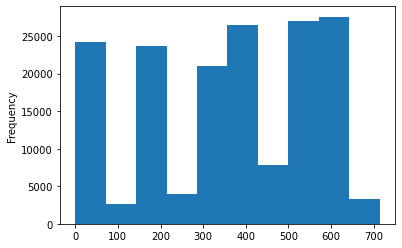

In [20]:
cleaned_transcript['time'].plot.hist()

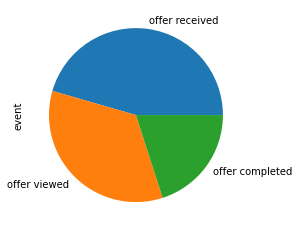

In [21]:
cleaned_transcript['event'].value_counts(normalize=True).plot(kind='pie')

### Profile Overview

In [22]:
cleaned_profile.head()

,gender,age,id,became_member_on,income,member_age
0,None,NaN,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,1386
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1233
2,None,NaN,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,871
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1300
4,None,NaN,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,1213


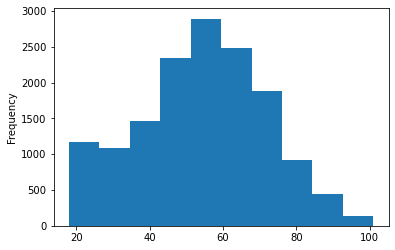

In [23]:
cleaned_profile['age'].plot.hist()

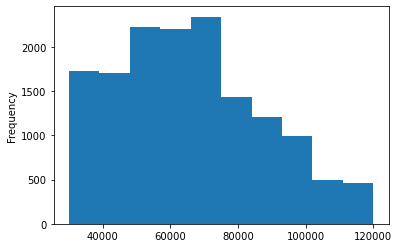

In [24]:
cleaned_profile['income'].plot.hist()

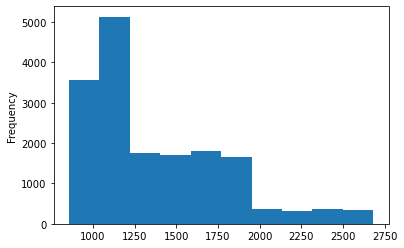

In [25]:
cleaned_profile['member_age'].plot.hist()

## Overview of all three and next steps

In [26]:
cleaned_portfolio.head()

,reward,difficulty,duration,id,web,email,mobile,social,bogo,discount,informational
0,10,10,168,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,96,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,0,1
3,5,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0
4,5,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,1,0


In [27]:
cleaned_transcript.head()

,person,event,time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [28]:
cleaned_profile.head()

,gender,age,id,became_member_on,income,member_age
0,None,NaN,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,1386
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1233
2,None,NaN,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,871
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1300
4,None,NaN,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,1213


Let's explore what we want to accomplish with the data. 
* We can see what attributes of a person are most important in determining whether they complete an offer or not.
* Similarly, we can see if different groups respond to mobile or web offers more.

In order to do accomplish this, we'll need to make the assumption that if a user views and offer and then completes it, that this counts as a "successful" offer.

We'll create a user-offer matrix that encodes an offer per user as either successful (1) or unsuccesful (0).

In [29]:
transcript_success = pd.pivot_table(data=cleaned_transcript, index=['person', 'offer_id'], columns=['event'], aggfunc='count').reset_index()
transcript_success.columns = ['person', 'offer_id', 'offer completed', 'offer received', 'offer viewed']
transcript_success.drop(columns=['offer received'], inplace=True) #since all users received an offer
transcript_success['offer completed'] = transcript_success['offer completed'].apply(lambda x: 1 if x >= 1 else 0)
transcript_success['offer viewed'] = transcript_success['offer viewed'].apply(lambda x: 1 if x >= 1 else 0)
transcript_success

,person,offer_id,offer completed,offer viewed
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,1
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,1
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1
...,...,...,...,...
63283,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,1,1
63284,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1
63285,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,1,1
63286,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1


In [30]:
transcript_success['success'] = transcript_success['offer completed'] + transcript_success['offer viewed']

# if the success column is equal to 2 (meaning someone viewed it and completed it) label as 1, else 0
# binary encoding will make the models faster
transcript_success['success'] = transcript_success['success'].apply(lambda x: 1 if x == 2 else 0)
transcript_success = transcript_success.drop(columns = ['offer completed', 'offer viewed'])
transcript_success

,person,offer_id,success
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1
...,...,...,...
63283,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,1
63284,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,1
63285,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,1
63286,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,1


Now let's merge in some additional one-hot encoded information about the particular offers. In particular, we'll want to encode the offer type and how it was delivered.

In [31]:
cleaned_portfolio.head()

,reward,difficulty,duration,id,web,email,mobile,social,bogo,discount,informational
0,10,10,168,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,96,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,0,1
3,5,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0
4,5,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,1,0


In [32]:
cleaned_portfolio.columns

Index(['reward', 'difficulty', 'duration', 'id', 'web', 'email', 'mobile',
       'social', 'bogo', 'discount', 'informational'],
      dtype='object')

In [33]:
success_details = pd.merge(left=transcript_success, 
                           right=cleaned_portfolio[['id', 'web', 'mobile', 'email', 'social', 'bogo', 'discount', 'informational']],
                          left_on='offer_id', 
                          right_on='id',
                          how='left').drop(columns=['id'])
success_details

,person,offer_id,success,web,mobile,email,social,bogo,discount,informational
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0,1,1,1,0,0,1,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,0,0,1
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,1,0,0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...
63283,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,1,0,0
63284,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,1,0,0,1,0
63285,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,1,1,1,1,0,0,1,0
63286,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,1,0,1,0,0


Now that we have a relatively useful matrix of offer success, let's plan the profile dataset a little more. 

In [34]:
cleaned_profile.head()

,gender,age,id,became_member_on,income,member_age
0,None,NaN,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,1386
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1233
2,None,NaN,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,871
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1300
4,None,NaN,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,1213


Let's one-hot encode gender.

In [35]:
cleaned_profile = pd.merge(cleaned_profile, pd.get_dummies(cleaned_profile['gender']), left_index=True, right_index=True)
cleaned_profile.drop(columns=['gender', 'became_member_on'], inplace=True)
cleaned_profile.head()

,age,id,income,member_age,F,M,O
0,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,1386,0,0,0
1,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,1233,1,0,0
2,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN,871,0,0,0
3,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1300,1,0,0
4,NaN,a03223e636434f42ac4c3df47e8bac43,NaN,1213,0,0,0


Let's add this to our *success_details* dataframe.

In [36]:
df = pd.merge(left=success_details,
             right=cleaned_profile,
             left_on='person',
             right_on='id',
             how='inner')
df.head()

,person,offer_id,success,web,mobile,email,social,bogo,discount,informational,age,id,income,member_age,F,M,O
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0,1,1,1,0,0,1,0,33.0,0009655768c64bdeb2e877511632db8f,72000.0,1318,0,1,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1,33.0,0009655768c64bdeb2e877511632db8f,72000.0,1318,0,1,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,0,0,1,33.0,0009655768c64bdeb2e877511632db8f,72000.0,1318,0,1,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,1,0,0,33.0,0009655768c64bdeb2e877511632db8f,72000.0,1318,0,1,0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,1,0,1,0,33.0,0009655768c64bdeb2e877511632db8f,72000.0,1318,0,1,0


In [37]:
df.drop(columns = ['person', 'offer_id', 'id'], inplace=True)
df.head()

,success,web,mobile,email,social,bogo,discount,informational,age,income,member_age,F,M,O
0,0,1,1,1,0,0,1,0,33.0,72000.0,1318,0,1,0
1,0,1,1,1,0,0,0,1,33.0,72000.0,1318,0,1,0
2,0,0,1,1,1,0,0,1,33.0,72000.0,1318,0,1,0
3,1,1,1,1,1,1,0,0,33.0,72000.0,1318,0,1,0
4,1,1,1,1,1,0,1,0,33.0,72000.0,1318,0,1,0


In [38]:
df.columns

Index(['success', 'web', 'mobile', 'email', 'social', 'bogo', 'discount',
       'informational', 'age', 'income', 'member_age', 'F', 'M', 'O'],
      dtype='object')

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63288 entries, 0 to 63287
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   success        63288 non-null  int64  
 1   web            63288 non-null  int64  
 2   mobile         63288 non-null  int64  
 3   email          63288 non-null  int64  
 4   social         63288 non-null  int64  
 5   bogo           63288 non-null  uint8  
 6   discount       63288 non-null  uint8  
 7   informational  63288 non-null  uint8  
 8   age            55222 non-null  float64
 9   income         55222 non-null  float64
 10  member_age     63288 non-null  int64  
 11  F              63288 non-null  uint8  
 12  M              63288 non-null  uint8  
 13  O              63288 non-null  uint8  
dtypes: float64(2), int64(6), uint8(6)
memory usage: 4.7 MB


### Note on missing values:
We can see that we have a number of missing data points in the age and income columns.

It's outside the scope of the assignment timelines to impute these values in a meaningful way. That leaves us with two options: remove the columns or remove the records.

Since we want to explore *which attributes* have the most impact on offer success, let's drop the records. If age and income don't seem to have much affect, we can go back to the model building and remove those columns to increase our sample.

In [40]:
df = df.dropna(how='any')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55222 entries, 0 to 63287
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   success        55222 non-null  int64  
 1   web            55222 non-null  int64  
 2   mobile         55222 non-null  int64  
 3   email          55222 non-null  int64  
 4   social         55222 non-null  int64  
 5   bogo           55222 non-null  uint8  
 6   discount       55222 non-null  uint8  
 7   informational  55222 non-null  uint8  
 8   age            55222 non-null  float64
 9   income         55222 non-null  float64
 10  member_age     55222 non-null  int64  
 11  F              55222 non-null  uint8  
 12  M              55222 non-null  uint8  
 13  O              55222 non-null  uint8  
dtypes: float64(2), int64(6), uint8(6)
memory usage: 4.1 MB


## Fine Tuning Functions for Data Pre-Processing
Let's combine some of this extra work into some handy functions for reusability.

In [41]:
# We'll add to our clean_profile function to add the one-hot encoding and dropping of missing values

def clean_profile(dataframe):
    """
    Cleans the Profile dataframe.
    
    INPUT: dataframe to clean
    OUTPUT: cleaned dataframe
    """
    df = profile.copy()
    df['age'] = df['age'].apply(lambda x: np.nan if x == 118 else x)
    
    df['became_member_on'] = pd.to_datetime(df['became_member_on'], format='%Y%m%d')
    df['member_age'] = datetime.datetime.today() - df['became_member_on']
    df['member_age'] = df['member_age'].dt.days
    df = pd.merge(df, pd.get_dummies(df['gender']), left_index=True, right_index=True)
    df.drop(columns=['gender', 'became_member_on'], inplace=True)
    df = df.dropna(how='any')
    
    return df

cleaned_profile = clean_profile(profile)
cleaned_profile.head()

,age,id,income,member_age,F,M,O
1,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,1233,1,0,0
3,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1300,1,0,0
5,68.0,e2127556f4f64592b11af22de27a7932,70000.0,948,0,1,0
8,65.0,389bc3fa690240e798340f5a15918d5c,53000.0,1024,0,1,0
12,58.0,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,1114,0,1,0


In [42]:
# Next, let's create a function that combines everything into a resulting df
def preprocess_data(cleaned_profile, cleaned_transcript, cleaned_portfolio):
    """Preprocesses the data for our model.
    INPUT:
    cleaned_profile = profile data processed by clean_profile()
    cleaned_transcript = transcript data processed by clean_transcript()
    cleaned_portfolio = cleaned portfolio data
    
    OUTPUT:
    df = preprocessed dataframe
    """
    transcript_success = pd.pivot_table(data=cleaned_transcript, index=['person', 'offer_id'], columns=['event'], aggfunc='count').reset_index()
    transcript_success.columns = ['person', 'offer_id', 'offer completed', 'offer received', 'offer viewed']
    transcript_success.drop(columns=['offer received'], inplace=True) #since all users received an offer
    transcript_success['offer completed'] = transcript_success['offer completed'].apply(lambda x: 1 if x >= 1 else 0)
    transcript_success['offer viewed'] = transcript_success['offer viewed'].apply(lambda x: 1 if x >= 1 else 0)
    transcript_success

    transcript_success['success'] = transcript_success['offer completed'] + transcript_success['offer viewed']

    # if the success column is equal to 2 (meaning someone viewed it and completed it) label as 1, else 0
    # binary encoding will make the models faster
    transcript_success['success'] = transcript_success['success'].apply(lambda x: 1 if x == 2 else 0)
    transcript_success = transcript_success.drop(columns = ['offer completed', 'offer viewed'])

    success_details = pd.merge(left=transcript_success, 
                               right=cleaned_portfolio[['id', 'web', 'mobile', 'email', 'social', 'bogo', 'discount', 'informational']],
                              left_on='offer_id', 
                              right_on='id',
                              how='left').drop(columns=['id'])
    df = pd.merge(left=success_details,
             right=cleaned_profile,
             left_on='person',
             right_on='id',
             how='inner')
    df.drop(columns = ['person', 'offer_id', 'id'], inplace=True)

    return df

df = preprocess_data(cleaned_profile, cleaned_transcript, cleaned_portfolio)
df.head()

,success,web,mobile,email,social,bogo,discount,informational,age,income,member_age,F,M,O
0,0,1,1,1,0,0,1,0,33.0,72000.0,1318,0,1,0
1,0,1,1,1,0,0,0,1,33.0,72000.0,1318,0,1,0
2,0,0,1,1,1,0,0,1,33.0,72000.0,1318,0,1,0
3,1,1,1,1,1,1,0,0,33.0,72000.0,1318,0,1,0
4,1,1,1,1,1,0,1,0,33.0,72000.0,1318,0,1,0


### Important note:
Since we want to determine what attributes are most important per offer type (bogo, discount, informational), we will remove the one hot encoding.

Instead, we'll run the analysis 3 times based on the different values of offer_type.

I modify the function about to recreate this data.

In [43]:
# Next, let's create a function that combines everything into a resulting df
def preprocess_data(cleaned_profile, cleaned_transcript, cleaned_portfolio, portfolio):
    """Preprocesses the data for our model.
    INPUT:
    cleaned_profile = profile data processed by clean_profile()
    cleaned_transcript = transcript data processed by clean_transcript()
    cleaned_portfolio = cleaned portfolio data
    
    OUTPUT:
    df = preprocessed dataframe
    """
    transcript_success = pd.pivot_table(data=cleaned_transcript, index=['person', 'offer_id'], columns=['event'], aggfunc='count').reset_index()
    transcript_success.columns = ['person', 'offer_id', 'offer completed', 'offer received', 'offer viewed']
    transcript_success.drop(columns=['offer received'], inplace=True) #since all users received an offer
    transcript_success['offer completed'] = transcript_success['offer completed'].apply(lambda x: 1 if x >= 1 else 0)
    transcript_success['offer viewed'] = transcript_success['offer viewed'].apply(lambda x: 1 if x >= 1 else 0)
    transcript_success

    transcript_success['success'] = transcript_success['offer completed'] + transcript_success['offer viewed']

    # if the success column is equal to 2 (meaning someone viewed it and completed it) label as 1, else 0
    # binary encoding will make the models faster
    transcript_success['success'] = transcript_success['success'].apply(lambda x: 1 if x == 2 else 0)
    transcript_success = transcript_success.drop(columns = ['offer completed', 'offer viewed'])

    success_details = pd.merge(left=transcript_success, 
                               right=cleaned_portfolio[['id', 'web', 'mobile', 'email', 'social', 'bogo', 'discount', 'informational']],
                              left_on='offer_id', 
                              right_on='id',
                              how='left').drop(columns=['id'])
    df = pd.merge(left=success_details,
             right=cleaned_profile,
             left_on='person',
             right_on='id',
             how='inner')
    
    df = pd.merge(left=df,
                 right=portfolio[['id', 'offer_type']],
                 left_on='offer_id',
                 right_on='id')
    
    df.drop(columns = ['person', 'offer_id', 'bogo', 'discount', 'informational', 'id_y', 'id_x'], inplace=True)

    return df

df = preprocess_data(cleaned_profile, cleaned_transcript, cleaned_portfolio, portfolio)
df.head()

,success,web,mobile,email,social,age,income,member_age,F,M,O,offer_type
0,0,1,1,1,0,33.0,72000.0,1318,0,1,0,discount
1,0,1,1,1,0,19.0,65000.0,1573,1,0,0,discount
2,0,1,1,1,0,56.0,47000.0,1086,0,1,0,discount
3,1,1,1,1,0,58.0,119000.0,1088,1,0,0,discount
4,1,1,1,1,0,26.0,61000.0,2170,0,1,0,discount


In [44]:
df.offer_type.unique()

array(['discount', 'informational', 'bogo'], dtype=object)

Our end goal here is to determine per offer_type what attributes most affect the success of an offer. Because of this, we'll end up with three different dataframes that we'll run the model against.

Let's create one final pre-processing function that creates these dataframes for us.

In [45]:
df.head()

,success,web,mobile,email,social,age,income,member_age,F,M,O,offer_type
0,0,1,1,1,0,33.0,72000.0,1318,0,1,0,discount
1,0,1,1,1,0,19.0,65000.0,1573,1,0,0,discount
2,0,1,1,1,0,56.0,47000.0,1086,0,1,0,discount
3,1,1,1,1,0,58.0,119000.0,1088,1,0,0,discount
4,1,1,1,1,0,26.0,61000.0,2170,0,1,0,discount


In [46]:
def get_dataframe(df, offer):
    """Generates dataframes to run model against.
    INPUT: 
    df = dataframe of all data
    offer = offer type to filter to
    
    OUTPUT: 
    filtered = dataframe filtered to specific offer type"""
    if offer in ['bogo', 'discount', 'informational']:
        return df[df['offer_type'] == f'{offer}'].copy().drop(columns=['offer_type'])
    else:
        print("Incorrect offer_type inputted")

# Model Building
Let's build some helpful functions to support building and implementing our model:

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier

In [48]:
def load_data(df, offer_type, test_size=0.20, random_state = 1):
    """
    Takes a dataframe and loads the data.
    
    INPUT:
    df = dataframe to use
    offer_type = offer type to use
    test_size = the proportion to be assigned to test
    random_state = the random state to use for reproducability
    
    OUTPUT:
    X_train, X_test = train and test split of target
    y_train, y_test = train and test split of features
    category_names = names of the headers as a list   
    """
    df = get_dataframe(df, f"{offer_type}")
    X = df.success
    y = df.drop(columns=['success'])
    category_names = y.columns.tolist()
    
    X_train, X_test, y_train, y_test = train_test_split(y,X, test_size=test_size, random_state=random_state)
    
    # Apply scaling to normalize huge spreads of data (e.g., income)
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)
    
    return X, y, X_train,X_test,y_train, y_test, category_names

We'll build a function that let's us assess the accuracy of different models.

We'll use a `build_model()` function and an `evaluate_model()` function, similar to the disaster response pipeline project.

In [49]:
def build_evaluate_model(X, y):
    """Evaluates the model and returns a cv and returns a cv.
    
    OUTPUT = dictionary of parameters"""

    parameters={'max_features': ['auto', 'sqrt'],
                'max_depth' : [5, 10, 15],
                'n_estimators': [10, 30]}

    grid_search = GridSearchCV(RandomForestClassifier(random_state=2), param_grid=parameters)
    grid_search.fit(X, y)
    parameters = grid_search.best_params_
    
    return parameters

In [50]:
X, y, X_train,X_test,y_train, y_test, category_names = load_data(df, 'bogo')
best_parameters_bogo = build_evaluate_model(X_train, y_train)
best_parameters_bogo

{'max_depth': 10, 'max_features': 'auto', 'n_estimators': 30}

## Model Refining
Now that we know the best parameters to use, let's apply these to each offer type.

In [51]:
def refined_model(df, offer_type):
    """Returns a refined model based on other functions.
    INPUT:
    df = dataframe to use
    offer_type = uses 'bogo', 'informational', 'discount'
    
    OUTPUT:
    model = a fitted model
    """
    
    X, y, X_train,X_test,y_train, y_test, category_names = load_data(df, offer_type, test_size=0.20, random_state = 1)
    parameters = build_evaluate_model(X_train, y_train)
    model = RandomForestClassifier(random_state=1,
                                   max_depth=parameters.get('max_depth'), 
                                   max_features= parameters.get('max_features'),
                                   n_estimators=parameters.get('n_estimators'))
    model.fit(X_train, y_train)
    return model

In [52]:
def plot_feature_importances(df, offer_type):
    """Takes a dataframe and offer_type and returns a dataframe of the feature importance."""
    X, y, X_train,X_test,y_train, y_test, category_names = load_data(df, offer_type, test_size=0.20, random_state = 1)
    model = refined_model(df, offer_type)
    features_df = pd.DataFrame(model.feature_importances_,
                               index = category_names,
                               columns = ['Feature Importance']).sort_values('Feature Importance',ascending=False)
#     features_df.plot.bar()

    return features_df

In [53]:
def get_feature_importance():
    """Returns the feature importance for different offer types."""
    feature_importances = pd.DataFrame()
    bogo = plot_feature_importances(df, 'bogo')
    bogo['Type'] = 'BOGO'
    feature_importances = feature_importances.append(bogo, sort=True)
    
    discount = plot_feature_importances(df, 'discount')
    discount['Type'] = 'Discount'
    feature_importances = feature_importances.append(discount, sort=True)
    feature_importances = feature_importances.reset_index()
    feature_importances = feature_importances.rename(columns={'index':'Feature'})
    return feature_importances

feature_importances = get_feature_importance()
feature_importances





,Feature,Feature Importance,Type
0,member_age,0.427533,BOGO
1,income,0.259364,BOGO
2,age,0.156312,BOGO
3,social,0.056133,BOGO
4,M,0.042292,BOGO
5,F,0.036512,BOGO
6,web,0.017980,BOGO
7,O,0.003874,BOGO
8,mobile,0.000000,BOGO
9,email,0.000000,BOGO


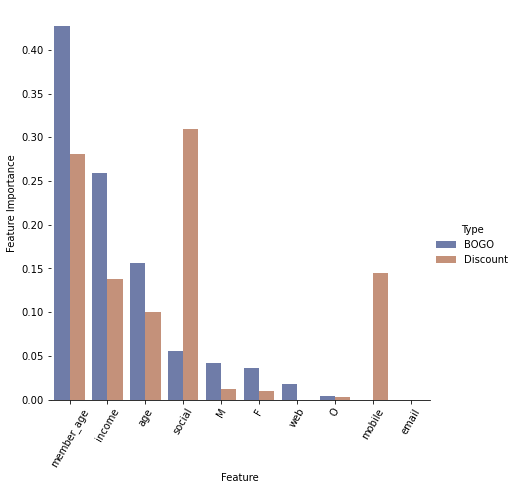

In [55]:
import seaborn as sns
g = sns.catplot(
    data=feature_importances, kind="bar",
    x="Feature", y="Feature Importance", hue="Type",
    palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("Feature", "Feature Importance")
g.set_xticklabels(rotation=60)